# Final Text Analytics Assignment - Amazon Prediction Problem Using BERT Embeddings and RNN model

### Final Assignment - Web and Text Analytics

This file contains the code for the fourth and final assignment in the Web and Text Analytics course. The purpose of this project is to analyze data from the `Amazon_Unlocked_Mobile.csv` file, which includes reviews of Amazon products. 

The analysis is performed using pre-trained embeddings based on BERT (Bidirectional Encoder Representations from Transformers) to extract meaningful representations of the text. These embeddings are then passed to a Recurrent Neural Network (RNN) model for sentiment analysis.

The following sections outline the process:
1. **Data Preparation**: Loading and preprocessing the Amazon reviews dataset.
2. **Embedding Generation**: Utilizing BERT to create sentence embeddings.
3. **Model Construction**: Building an RNN model with LSTM layers for sentiment classification.
4. **Training and Evaluation**: Training the model and assessing its performance on a test set.

This code aims to showcase the integration of state-of-the-art NLP techniques with deep learning models to extract insights from textual data.


In [1]:
#Indicator of GPU usage
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2025-01-07 12:49:01.975209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736254141.997733   12717 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736254142.004649   12717 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 12:49:02.029718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available: 1


In [2]:
#Importing packages 
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

In [3]:
# Read in the data
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
df = df.sample(frac=1.00, random_state=10) #Using only 10% of the data for better performance 
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
394349,Sony XPERIA Z2 D6503 FACTORY UNLOCKED Internat...,NaN,244.95,5,Very good one! Better than Samsung S and iphon...,0.0
34377,Apple iPhone 5c 8GB (Pink) - Verizon Wireless,Apple,194.99,1,"The phone needed a SIM card, would have been n...",1.0
248521,Motorola Droid RAZR MAXX XT912 M Verizon Smart...,Motorola,174.99,5,I was 3 months away from my upgrade and my Str...,3.0
167661,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,1,an experience i want to forget,0.0
73287,Apple iPhone 7 Unlocked Phone 256 GB - US Vers...,Apple,922.00,5,GREAT PHONE WORK ACCORDING MY EXPECTATIONS.,1.0


In [4]:
# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (rated positively)
# Encode 1s and 2s as 0 (rated poorly)
df['Positively Rated'] = np.where(df['Rating'] > 3, 1, 0)
df.head(5)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Positively Rated
34377,Apple iPhone 5c 8GB (Pink) - Verizon Wireless,Apple,194.99,1,"The phone needed a SIM card, would have been n...",1.0,0
248521,Motorola Droid RAZR MAXX XT912 M Verizon Smart...,Motorola,174.99,5,I was 3 months away from my upgrade and my Str...,3.0,1
167661,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,1,an experience i want to forget,0.0,0
73287,Apple iPhone 7 Unlocked Phone 256 GB - US Vers...,Apple,922.00,5,GREAT PHONE WORK ACCORDING MY EXPECTATIONS.,1.0,1
277158,Nokia N8 Unlocked GSM Touch Screen Phone Featu...,Nokia,95.00,5,I fell in love with this phone because it did ...,0.0,1


In [5]:
#Load the dataset
reviews = df['Reviews'].tolist()
print(reviews[1])

#Preprocess reviews to tokenize them
processed_reviews = [sentence.lower().split() for sentence in reviews]
print(processed_reviews[1])

I was 3 months away from my upgrade and my Stratosphere kept crapping out on me. I didn't want to wait and every time Verizon sent me a new Stratosphere it would work fine for a few days and then it would crap out. I didn't want the HD version of this phone so I decided to try Amazon. They had a used one sold by GottaGetaPhone. It's works great!! I can't even tell that it was used. The battery lasts me 2 to 3 days between charges depending on usage. And best part is that I've had it for a month and it hasn't crapped out on me!!
['i', 'was', '3', 'months', 'away', 'from', 'my', 'upgrade', 'and', 'my', 'stratosphere', 'kept', 'crapping', 'out', 'on', 'me.', 'i', "didn't", 'want', 'to', 'wait', 'and', 'every', 'time', 'verizon', 'sent', 'me', 'a', 'new', 'stratosphere', 'it', 'would', 'work', 'fine', 'for', 'a', 'few', 'days', 'and', 'then', 'it', 'would', 'crap', 'out.', 'i', "didn't", 'want', 'the', 'hd', 'version', 'of', 'this', 'phone', 'so', 'i', 'decided', 'to', 'try', 'amazon.', 't

In [6]:
torch.cuda.empty_cache() #Clear the cache
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Activate GPU

# Load the pre-trained BERT tokenizer to convert input text into tokens suitable for the BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT model (base version, uncased), and move it to the selected device (GPU or CPU)
model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [7]:
#Define a function to generate BERT embeddings
def get_bert_embedding(sentence, tokenizer, model):
    #Tokenize the sentence and convert to input IDs and attention masks
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    #Pass the inputs through the BERT model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    #Use the [CLS] token's embedding as the sentence embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # Move to CPU for compatibility
    return cls_embedding

In [8]:
#Generate embeddings for all reviews using BERT
reviews = df['Reviews'].tolist()
bert_embeddings = [get_bert_embedding(review, tokenizer, model) for review in reviews]

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split

#Prepare data for training
bert_embeddings = np.array(bert_embeddings) #Convert BERT embeddings to a NumPy array

#Extract labels
labels = df['Positively Rated'].values

#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, labels, test_size=0.2, random_state=42)

In [10]:
#Build the LSTM model
model = Sequential([
    Input(shape=(bert_embeddings.shape[1],)),  #Input layer matching the size of BERT embeddings
    tf.keras.layers.Reshape((1, bert_embeddings.shape[1])),  #Reshape to make it compatible with LSTM
    LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),  #LSTM layer
    Dense(64, activation='relu'),  #Dense layer
    Dropout(0.5),  #Dropout layer to reduce overfitting
    Dense(1, activation='sigmoid')  #Output layer with sigmoid activation for binary classification
])

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

#Evaluate the model
eval_results = model.evaluate(X_test, y_test)
print("Test Accuracy:", eval_results[1])

I0000 00:00:1736256855.468248   12717 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13240 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Epoch 1/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.9129 - loss: 0.2198 - val_accuracy: 0.9350 - val_loss: 0.1656
Epoch 2/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.9295 - loss: 0.1792 - val_accuracy: 0.9388 - val_loss: 0.1572
Epoch 3/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.9348 - loss: 0.1674 - val_accuracy: 0.9442 - val_loss: 0.1463
Epoch 4/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.9387 - loss: 0.1586 - val_accuracy: 0.9458 - val_loss: 0.1412
Epoch 5/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.9414 - loss: 0.1522 - val_accuracy: 0.9477 - val_loss: 0.1376
Epoch 6/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.9431 - loss: 0.1490 - val_accuracy: 0.9501 - val_loss: 0.1334
Epoch 7/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.9460 - loss: 0.1416 - val_accuracy: 0.9518 - val_loss: 0.1293
Epoch 8/10
7707/7707 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.9486 - loss: 0

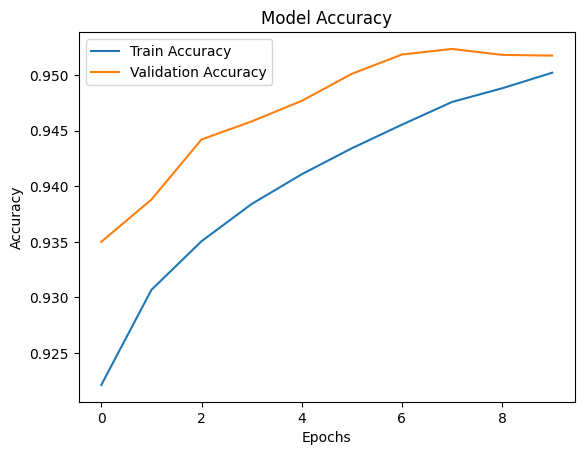

In [11]:
#Visualize training history 
import matplotlib.pyplot as plt

#Model Accuracy History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

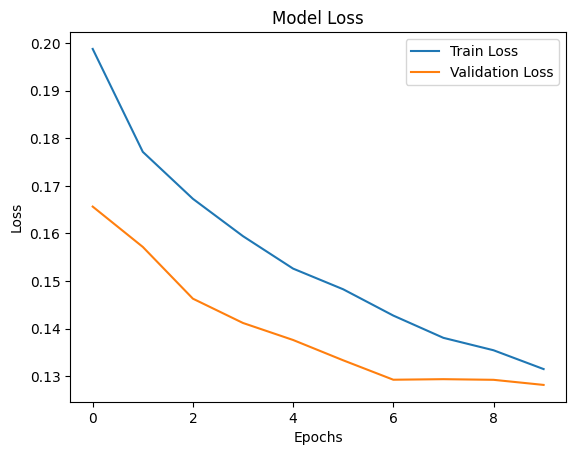

In [12]:
#Model Loss History
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

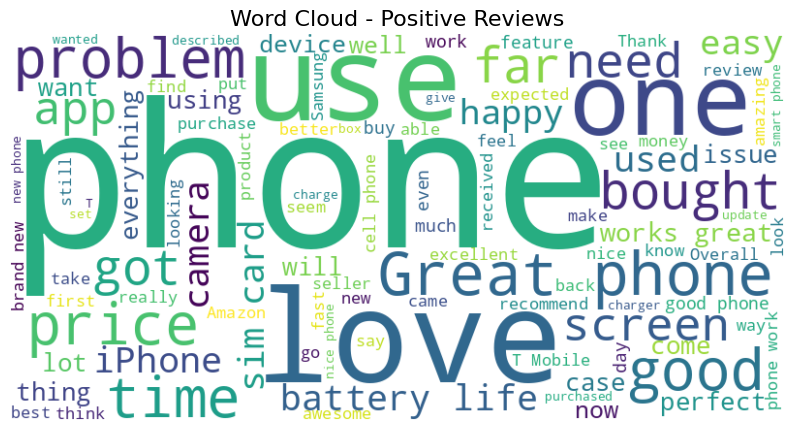

In [13]:
from wordcloud import WordCloud

#Filtering all positive reviews
positive_reviews = df[df['Rating'] >= 4]['Reviews']

#Converting all reviews into one string
text_data = ' '.join(positive_reviews)

#Positive WordCloud
wordcloud = WordCloud(width=800,height=400,background_color='white',colormap='viridis',max_words=100).generate(text_data)

#Vizualize Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title('Word Cloud - Positive Reviews', fontsize=16)
plt.show()

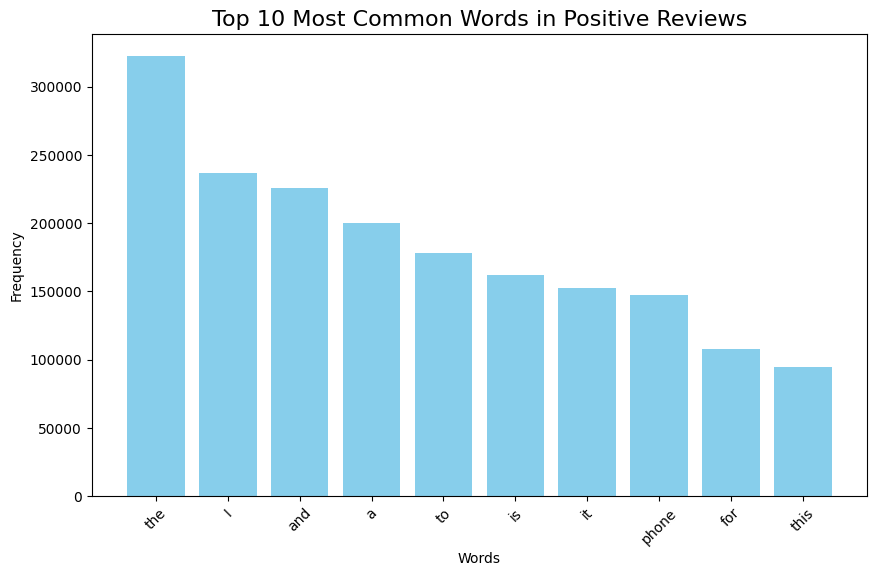

In [14]:
from collections import Counter

#Calculating word frequency in posotive comments
positive_word_list = text_data.split()  
word_counts = Counter(positive_word_list)  
common_words = word_counts.most_common(10)  

#Making a DataFrame for the most common positive words
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

#Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(common_words_df['Word'], common_words_df['Frequency'], color='skyblue')
plt.title('Top 10 Most Common Words in Positive Reviews', fontsize=16)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

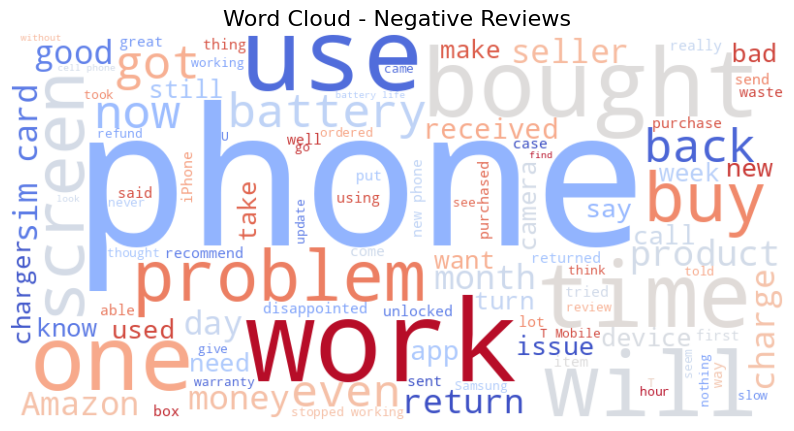

In [15]:
#Filtering all negative reviews
negative_reviews = df[df['Rating'] <= 2]['Reviews']

#Converting all reviews into one string
negative_text_data = ' '.join(negative_reviews)

#Negative WordCloud
negative_wordcloud = WordCloud(width=800,height=400,background_color='white',colormap='coolwarm',max_words=100).generate(negative_text_data)

#Vizualize Word Cloud for Negative reviews
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Reviews', fontsize=16)
plt.show()

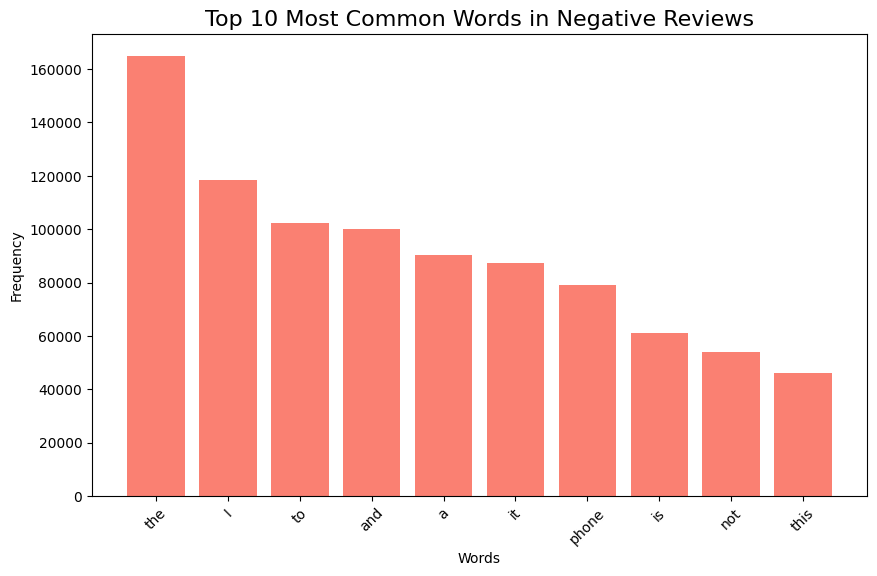

In [16]:
#Calculating word frequency in negative comments
negative_word_list = negative_text_data.split()  
negative_word_counts = Counter(negative_word_list) 
negative_common_words = negative_word_counts.most_common(10) 

#Making a DataFrame for the most common negative words
negative_common_words_df = pd.DataFrame(negative_common_words, columns=['Word', 'Frequency'])

#Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(negative_common_words_df['Word'], negative_common_words_df['Frequency'], color='salmon')
plt.title('Top 10 Most Common Words in Negative Reviews', fontsize=16)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()